# Dataset 

In [1]:
import sys
sys.path.append('../../datasets/')
from prepare_sequences import prepare, germanBats
import matplotlib.pyplot as plt
import pickle
import numpy as np

classes = germanBats

In [2]:
num_bands = 257
patch_len = 44                               # = 250ms ~ 25ms
patch_skip = patch_len / 2                   # = 150ms ~ 15ms

resize = None

mode = 'slide'
options = {
    'seq_len': 60,                            # = 500ms with ~ 5 calls
    'seq_skip': 15,
}

X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare("../../datasets/prepared.h5", classes, patch_len, patch_skip,
                                                         options, mode, resize)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:17<00:00,  1.01it/s]


In [3]:
print("Total sequences:", len(X_test))
print(X_test.shape, Y_test.shape)

Total sequences: 4979
(4979, 60, 44, 257) (4979,)


# Model

In [4]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 1

test_data = TensorDataset(torch.Tensor(X_test), torch.from_numpy(Y_test))
test_loader = DataLoader(test_data, batch_size=batch_size)

In [5]:
from baseline import ResNet, Block

model = ResNet(18, image_channels=1, num_classes=len(list(classes)))
model.load_state_dict(torch.load('baseline.pth'))
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
model.to(device)
print(device)

cuda:0


In [9]:
call_nocall_model = torch.jit.load('../call_nocall/call_nocall.pt')
call_nocall_model.to(device)
print(device)

cuda:0


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import tqdm

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
    inputs, labels = inputs[0].to(device).unsqueeze(1), labels[0].to(device)
    cnc_outputs = call_nocall_model(inputs)
    _, cnc_pred = torch.max(cnc_outputs, 1) # call indices
    
    n_inputs = inputs[cnc_pred.nonzero().squeeze()]
    if n_inputs.shape[0] > 1:
        output = model(n_inputs)
        pred = torch.max(output, 1)[1]
        pred = torch.mode(pred)[0].item()
        Y_pred.append(pred) # Save Prediction
        Y_true.append(labels.item()) # Save Truth
    else:
        Y_pred.append(17-labels.item()) # Save Prediction
        Y_true.append(labels.item()) # Save Truth

In [35]:
print(len(Y_pred), len(Y_true))

4979 4979


/tmp/ipykernel_454468/3270112565.py:5: RuntimeWarning: invalid value encountered in true_divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=0), index = [i for i in classes],


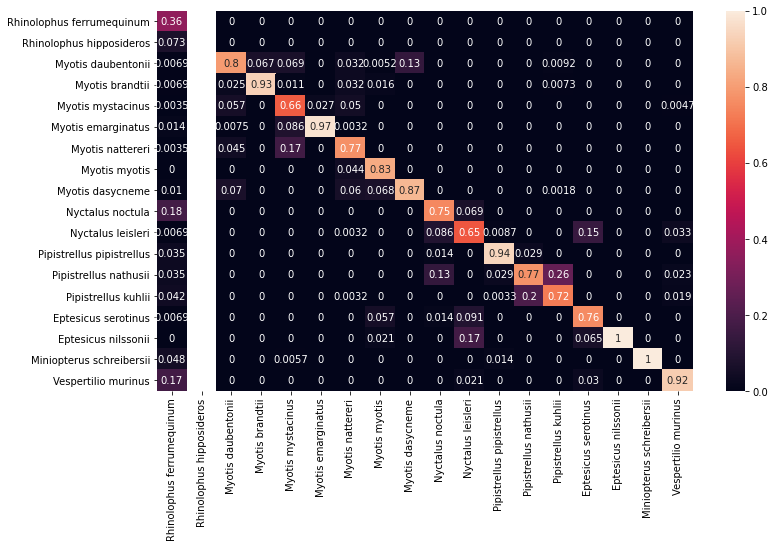

In [33]:
import numpy as np

# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=0), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('seq_test_cf.png')

In [36]:
from sklearn.metrics import f1_score
corrects = np.equal(Y_pred, Y_true).sum()
print("Test accuracy:", corrects/len(Y_pred))
print("F1-score:", f1_score(Y_true, Y_pred, average=None).mean())

Test accuracy: 0.7852982526611769
F1-score: 0.7030412440827722


In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)